In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample


In [2]:
df = pd.read_csv("Creditcard_data.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Class'].value_counts()


,count
Class,
0,763
1,9


In [4]:
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

non_fraud_sampled = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud),
    random_state=42
)

balanced_df = pd.concat([fraud, non_fraud_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42)

balanced_df['Class'].value_counts()


,count
Class,
1,9
0,9


In [5]:
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
def simple_random_sampling(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
def bootstrap_sampling(X, y):
    X_res, y_res = resample(X, y, replace=True, random_state=42)
    return train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [15]:
def cluster_sampling(X, y):
    df_temp = pd.DataFrame(X)
    df_temp['Class'] = y.values

    clusters = np.array_split(df_temp, 5)

    selected_clusters = pd.concat(clusters[:3])  # take 3 clusters

    X_c = selected_clusters.drop('Class', axis=1)
    y_c = selected_clusters['Class']

    return train_test_split(X_c, y_c, test_size=0.3, stratify=y_c, random_state=42)


In [16]:
def stratified_sampling(X, y):
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [17]:
def systematic_sampling(X, y):
    df_temp = pd.DataFrame(X)
    df_temp['Class'] = y.values

    df_temp = df_temp.sample(frac=1, random_state=42)

    step = 2
    systematic_sample = df_temp.iloc[::step]

    X_s = systematic_sample.drop('Class', axis=1)
    y_s = systematic_sample['Class']

    return train_test_split(X_s, y_s, test_size=0.3, stratify=y_s, random_state=42)


In [18]:
models = {
    "M1_LogisticRegression": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(),
    "M3_RandomForest": RandomForestClassifier(),
    "M4_SVM": SVC(),
    "M5_NaiveBayes": GaussianNB()
}


In [19]:
sampling_methods = {
    "Sampling1_SimpleRandom": simple_random_sampling,
    "Sampling2_Bootstrap": bootstrap_sampling,
    "Sampling3_Cluster": cluster_sampling,
    "Sampling4_Stratified": stratified_sampling,
    "Sampling5_Systematic": systematic_sampling
}

results = pd.DataFrame(index=models.keys(), columns=sampling_methods.keys())

for s_name, sampler in sampling_methods.items():
    X_train, X_test, y_train, y_test = sampler(X_scaled, y)

    for m_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred) * 100
        results.loc[m_name, s_name] = round(acc, 2)


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [20]:
results


,Sampling1_SimpleRandom,Sampling2_Bootstrap,Sampling3_Cluster,Sampling4_Stratified,Sampling5_Systematic
M1_LogisticRegression,33.33,83.33,50.0,16.67,66.67
M2_DecisionTree,66.67,100.0,100.0,83.33,33.33
M3_RandomForest,66.67,83.33,75.0,50.0,100.0
M4_SVM,50.0,83.33,0.0,16.67,66.67
M5_NaiveBayes,50.0,83.33,50.0,66.67,66.67


In [21]:
best_sampling = results.astype(float).idxmax(axis=1)
best_sampling


,0
M1_LogisticRegression,Sampling2_Bootstrap
M2_DecisionTree,Sampling2_Bootstrap
M3_RandomForest,Sampling5_Systematic
M4_SVM,Sampling2_Bootstrap
M5_NaiveBayes,Sampling2_Bootstrap


In [22]:

results_float = results.astype(float)

results_float.to_csv("sampling_vs_models_accuracy.csv")

print("CSV file saved as sampling_vs_models_accuracy.csv")


CSV file saved as sampling_vs_models_accuracy.csv


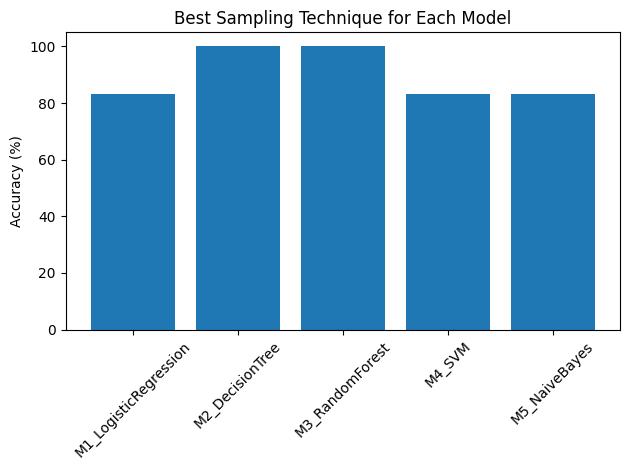

In [24]:
import matplotlib.pyplot as plt

best_sampling = results_float.idxmax(axis=1)
best_accuracy = results_float.max(axis=1)

plt.figure()
plt.bar(best_sampling.index, best_accuracy.values)
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Best Sampling Technique for Each Model")
plt.tight_layout()

plt.savefig("best_sampling_per_model.png", dpi=300)
plt.show()
